# Credit Risk Assessment: Baseline Logistic Regression Model

---

### Import Libraries and set Configurations

In [1]:
import numpy as np
import warnings
import pandas as pd
from pathlib import Path
from scipy import sparse
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,roc_auc_score, accuracy_score, RocCurveDisplay, average_precision_score)
import joblib
import matplotlib.pyplot as plt
from aura.utils.pathing import models,reports, root
from datetime import date
import json

data = Path("../../data/processed")
random_state=42
warnings.filterwarnings("ignore")
stamp = date.today().isoformat()

### Load Data

In [2]:
X_train = sparse.load_npz(data/"X_train.npz")
X_test = sparse.load_npz(data/"X_test.npz")
y_train = pd.read_csv(data/"y_train.csv").squeeze("columns")
y_test = pd.read_csv(data/"y_test.csv").squeeze("columns")
print("train", X_train.shape, " test", X_test.shape)
print("class balance:\n", y_train.value_counts(normalize=True).round(3))

train (1076248, 134)  test (269062, 134)
class balance:
 default
0    0.8
1    0.2
Name: proportion, dtype: float64


### Train Logistic Regression Model

In [3]:
logreg_path = models / "logreg_v1_2025-06-05.joblib"
meta_path = models / "logreg_meta_2025-06-05.json"
if logreg_path.exists():
    print("using cached Logitistic Regression model")
    logreg = joblib.load(logreg_path)
    with open(meta_path) as fp:
        meta = json.load(fp)
else:
    print("No cached model found, training new Logistic Regression model")
    logistic_regression = LogisticRegression(
        max_iter=500,
        solver="saga",
        random_state=random_state,
        n_jobs=1,
        class_weight="balanced"
    )

    logistic_regression.fit(X_train, y_train)
    print("Model Fitted")

    stamp = date.today().isoformat()          
    model_name = f"logreg_v1_{stamp}.joblib"
    joblib.dump(logistic_regression, models / model_name)

    meta = {
        "date": stamp,
        "solver": logistic_regression.solver,
        "penalty": logistic_regression.penalty,
        "C": float(logistic_regression.C),
        "class_weight": logistic_regression.class_weight,
    }
    with open(models / f"logreg_meta_{stamp}.json", "w") as fp:
        json.dump(meta, fp, indent=2)

    print("model saved to", (models / model_name).resolve())

using cached Logitistic Regression model


### Evaluation Metics on Baseline Logistic Regression Model

ROC-AUC: 0.9554 | PR-AUC: 0.844
              precision    recall  f1-score   support

           0      0.973     0.901     0.935    215350
           1      0.693     0.899     0.783     53712

    accuracy                          0.900    269062
   macro avg      0.833     0.900     0.859    269062
weighted avg      0.917     0.900     0.905    269062

Confusion Matrix:
 [[193950  21400]
 [  5415  48297]]


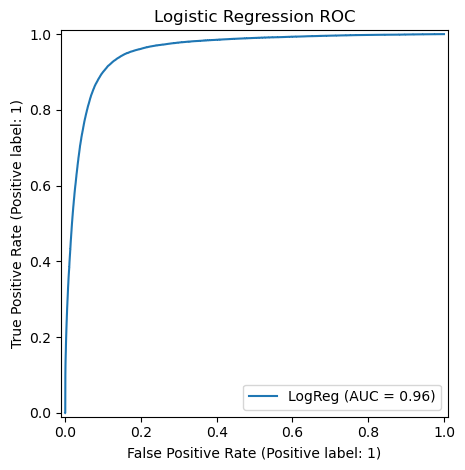

In [7]:
y_proba = logreg.predict_proba(X_test)[:, 1]
y_pred  = (y_proba > 0.50).astype(int)                

auc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)
print(f"ROC-AUC: {auc:.4f} | PR-AUC: {pr_auc:.3f}")
print(classification_report(y_test, y_pred, digits=3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

RocCurveDisplay.from_predictions(y_test, y_proba, name="LogReg")
plt.title("Logistic Regression ROC");  plt.tight_layout()
plt.savefig(reports / "figs" / "roc_logreg.png", dpi=300)
plt.show()

### Save Model

In [5]:
auc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)
report = classification_report(y_test, y_pred, digits=3)

md = reports / "metrics_logreg.md"
with open(md, "w") as f:
    f.write(f"# Logistic Regression – {stamp}\n\n")
    f.write(f"* **ROC-AUC:** `{auc:.4f}`\n")
    f.write(f"* **PR-AUC:**  `{pr_auc:.3f}`\n\n")
    f.write("```text\n" + report + "\n```")

print("metrics written to", md.relative_to(root))

metrics written to reports/metrics_logreg.md
